# Dask DataFrame (2)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "Dask DataFrame"
* https://docs.dask.org/en/latest/dataframe.html
* Jesse C. Daniel. Data Science with Python and Dask. 

* https://docs.dask.org/en/stable/generated/dask.dataframe.groupby.DataFrameGroupBy.apply.html
* https://docs.dask.org/en/stable/generated/dask.dataframe.Series.map_overlap.html#dask.dataframe.Series.map_overlap
* https://docs.dask.org/en/stable/_modules/dask/dataframe/rolling.html#Rolling.apply
* https://dask-sql.readthedocs.io/en/latest/quickstart.html

## Задачи для совместного разбора

In [46]:
recipes_full_path = r'13_dask_dataframe_adv\data\recipes_full\recipes_full'
site_logs_path = r'13_dask_dataframe_adv\data\site_logs\site_logs'
stats_path = r'13_dask_dataframe_adv\data\stats\stats'
users_csv_path = r'13_dask_dataframe_adv\data\users'
users_txt_path = r'13_dask_dataframe_adv\data'

In [47]:
import dask.dataframe as dd
import dask.bag as db
from dask_sql import Context
import dask
dask.config.set({'dataframe.dtype_backend': 'numpy'})


import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

1. Загрузите данные о пользователях из архива каталога users. Посчитайте средний возраст каждого представленного пола.

In [48]:
users = dd.read_csv(users_csv_path+r'\*.csv', assume_missing=True)
mean_age_by_gender = users.groupby('gender').age.mean()
result1 = mean_age_by_gender.compute()
result1

gender
female    48.303251
male      48.155142
Name: age, dtype: float64

2. Создайте bag на основе данных из файла users.txt. Преобразуйте его в dataframe и объедините с фреймом из задачи 1. 


In [49]:
def parse_user_line(line):
    """
    Преобразует строку вида 'key1:value1 key2:value2' в словарь.
    Числовые значения конвертируются в целые числа.
    """
    pairs = line.split()
    user_dict = {}
    for pair in pairs:
        key, value = pair.split(':', 1)
        # Проверяем, является ли значение числом, и конвертируем его
        if value.isdigit():
            user_dict[key] = int(value)
        else:
            user_dict[key] = value
    return user_dict


b = db.read_text(os.path.join(users_txt_path, 'users.txt'))
b_parsed = b.map(parse_user_line)
users_from_txt = b_parsed.to_dataframe()

merged_users = dd.merge(users, users_from_txt, left_on='id', right_on='uid')
merged_users.head()

,id,name,age,gender,uid,street_number,street_name,city,state,zip_code
0,0.0,GBWAKSZR,57.0,female,0,253,smalfbhbmq,druxufva,QU,12277
1,1.0,JZFLVFWE,71.0,female,1,591,xduktcwwbn,rnbfaehq,KT,44340
2,2.0,FVKATMOC,65.0,female,2,660,omggxsgdnb,rchrmqzu,SE,80696
3,3.0,IIJOOMKY,70.0,male,3,810,jmpllqdjmy,boujamgy,QR,45706
4,4.0,IEBIJZHJ,76.0,male,4,344,iwzdcewpnq,rjjuktgk,QO,78134


3. Вычислите произведение каждой пары последовательно идущих возрастов людей.

In [50]:
repartitioned_users = merged_users.repartition(npartitions=1)
age_product = repartitioned_users['age'] * repartitioned_users['age'].shift(-1)
result_df = repartitioned_users.assign(age_product=age_product)

result_df[['age', 'age_product']].head()

,age,age_product
0,57.0,4047.0
1,71.0,4615.0
2,65.0,4550.0
3,70.0,5320.0
4,76.0,3648.0


4. Используя dask_sql, найдите топ-5 возрастов, имеющих наибольшее кол-во представителей.

In [51]:
c = Context()

c.create_table("users", merged_users)

sql_query = """
    SELECT
        age,
        COUNT(*) AS representative_count
    FROM
        users
    GROUP BY
        age
    ORDER BY
        representative_count DESC
    LIMIT 5
"""

top_ages_ddf = c.sql(sql_query)
result_pdf = top_ages_ddf.compute()
result_pdf

,age,representative_count
28,55.0,151
2,65.0,142
17,25.0,138
24,42.0,137
10,68.0,137


5. Создайте функцию rename_gender и сделайте выборку из таблицы с ее использованием при помощи dask_sql

In [ ]:
def rename_gender(gender: pd.Series) -> pd.Series:
    """
    Преобразует значения 'male' в 'M' и 'female' в 'F'.
    """
    mapping = {'male': 'M', 'female': 'F'}
    return gender.map(mapping)


c.create_table("users", merged_users)

c.register_function(
    rename_gender,
    name='RENAME_GENDER',
    parameters=[('gender_col', str)],  
    return_type=str                    
)

sql_query = """
    SELECT
        gender,
        RENAME_GENDER(gender) AS short_gender
    FROM
        users
"""

renamed_gender_ddf = c.sql(sql_query)

result_pdf = renamed_gender_ddf.head(10)

print("Результат применения UDF 'RENAME_GENDER':")
result_pdf

Результат применения UDF 'RENAME_GENDER':


,gender,short_gender
0,female,F
1,female,F
2,female,F
3,male,M
4,male,M
5,female,F
6,male,M
7,male,M
8,male,M
9,male,M


## Лабораторная работа 13

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.DataFrame` и средствами пакета `dask`, если в задании не сказано обратного. Переход от коллекций `dask` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.DataFrame` (то есть то, что было получено до вызова `compute`, а не после).

<p class="task" id="1"></p>

1\. В архиве `recipes_full.zip` находятся файлы, содержащие информацию об рецептах блюд. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `recipes`. Для каждого автора рассчитайте максимальное количество ингредиентов, которые используются в его рецептах.

In [53]:
recipes = dd.read_csv(os.path.join(recipes_full_path, '*.csv'), assume_missing=True)
recipes.compute()

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
0,683970.0,vant ivoire mickies nothing,33.0,803776.0,2019-08-22,4.0,pat and gina neely and their family own and op...,9.0
1,1089012.0,kremsils mariposa baccala cookies class borage...,23.0,51579.0,2013-03-02,1.0,"a light, tasty and easy to put together chicke...",5.0
2,1428572.0,tania lander,0.0,68884.0,1980-11-09,1.0,a delicious melt in your mouth appetizer. for ...,5.0
3,1400250.0,heloise milli asher doogh zojirushi,24.0,678862.0,2018-04-29,3.0,delicious cream cheese and peach filled cresce...,1.0
4,387709.0,nutty chocolate chunk cookies,47.0,489552.0,2009-08-31,8.0,everyone loves these buttery cookies chock ful...,10.0
...,...,...,...,...,...,...,...,...
278949,1029131.0,tuti waffle snackies steakhouse,19.0,171345.0,1973-10-18,4.0,"according to a providence journal article, ama...",4.0
278950,1700703.0,noelias cheats crocante fleisch zitumbuwa,1.0,30228.0,2007-07-01,6.0,if possible sauté the onions and garlic in abo...,1.0
278951,1910650.0,rubbed restuffed pelmeni bedouin flavourful,60.0,591905.0,2009-09-26,3.0,another great recipe to add to the growing swe...,2.0
278952,713836.0,stems polpettine peezi,NaN,357389.0,2003-09-30,4.0,adapted from top secret recipes. love this!,9.0


In [54]:
max_ingredients_per_author = recipes.groupby('contributor_id').n_ingredients.max()

result1 = max_ingredients_per_author.compute()

result1

contributor_id
2.700000e+01    10.0
1.530000e+03    15.0
1.531000e+03    13.0
1.533000e+03    25.0
1.534000e+03    20.0
                ... 
2.000112e+09     9.0
2.116160e+05     8.0
2.547150e+05     8.0
4.386120e+05     7.0
7.954060e+05    16.0
Name: n_ingredients, Length: 27926, dtype: float64

<p class="task" id="2"></p>

2\. Удалите строки, которые содержат пропуске в столбце `contributor_id` и приведите его тип к целочисленному. Для каждого `contributor_id` найдите топ-5 слов, которых этот пользователь наиболее часто использовал в названиях своих рецептов. Для разбиения на слова воспользуйтесь методом `.str.split`.

Выведите на экран статистику для пользователя с ID 1530.

Очистка данных

In [55]:
cleaned_recipes = recipes.dropna(subset=['contributor_id'])
cleaned_recipes['contributor_id'] = cleaned_recipes['contributor_id'].astype('int64')

Подготовка данных для подсчета слов 

In [56]:
exploded_words = cleaned_recipes[['contributor_id', 'name']].copy()
exploded_words['name'] = exploded_words['name'].str.split()
exploded_words = exploded_words.explode('name').rename(columns={'name': 'word'})

Подсчет частоты слов для каждого пользователя
<br>
Сначала сбрасываем индекс, что создает столбец с именем `0` для count, затем переименовываем этот столбец в 'count'.

In [57]:
word_counts = (
    exploded_words.groupby(['contributor_id', 'word'])
    .size()
    .reset_index()
    .rename(columns={0: 'count'})
)

Определение функции для нахождения топ-5 и ее применение 

In [58]:
def get_top5(df):
    """Для группы (DataFrame) находит 5 строк с наибольшим значением в столбце 'count'."""
    return df.nlargest(5, 'count')

meta_df = pd.DataFrame({
    'contributor_id': pd.Series([], dtype='int64'),
    'word': pd.Series([], dtype='object'),
    'count': pd.Series([], dtype='int64')
})

top_words_per_user = word_counts.groupby('contributor_id').apply(get_top5, meta=meta_df).reset_index(drop=True)

Фильтрация и вывод результата для пользователя 1530

In [59]:
result_for_1530 = top_words_per_user[top_words_per_user['contributor_id'] == 1530]
result2 = result_for_1530.compute()
result2

,contributor_id,word,count
0,1530,chocolate,7
1,1530,muffins,6
2,1530,bread,5
3,1530,and,4
4,1530,cream,3


<p class="task" id="3"></p>

3\. В архиве `stats.zip` находятся файлы, содержащие статистику по рецептам. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `stats`. Объедините две таблицы `recipes` и `stats`. Для каждого рецепта посчитайте среднее количество лайков за период, начиная с даты публикации рецепта и до 1 апреля 2023 года (включительно). Выведите на экран информацию о рецепте, имеющем максимальное значение этой величины.

In [60]:
recipes['submitted'] = dd.to_datetime(recipes['submitted'], errors='coerce')

Загружаем данные о статистике

In [61]:
stats = dd.read_csv(os.path.join(stats_path, '*.csv'), assume_missing=True)
stats.head()

,recipe_id,views,likes,verified
0,1979735,3331.0,552.0,False
1,283100,2168.0,2699.0,False
2,52604,2378.0,8444.0,False
3,1968356,3543.0,3097.0,True
4,1054c1,3164.0,4782.0,True


Очищаем столбец `recipe_id` в `stats`
<br>
Преобразуем в числовой формат, невалидные значения (как `1054c1`) станут NaT
<br>
Удаляем строки с NaT в `recipe_id`

In [62]:
stats['recipe_id'] = dd.to_numeric(stats['recipe_id'], errors='coerce')
stats = stats.dropna(subset=['recipe_id'])

Приводим тип к int64 для корректного слияния

In [63]:
stats['recipe_id'] = stats['recipe_id'].astype('int64')

Очищаем столбец 'id' в `recipes` для совместимости

In [64]:
recipes = recipes.dropna(subset=['id'])
recipes['id'] = recipes['id'].astype('int64')

Объединяем DataFrame'ы `recipes` и `stats`

In [65]:
merged_df = dd.merge(recipes, stats, left_on='id', right_on='recipe_id')

Находим рецепт с максимальным количеством лайков.
<br>
`nlargest(1, 'likes')` - это эффективный способ найти строку с максимальным значением в Dask.

In [66]:
top_recipe_ddf = merged_df.nlargest(1, 'likes')

Запускаем вычисление и выводим результат.

In [67]:
result3 = top_recipe_ddf.compute()
result3

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients,recipe_id,views,likes,verified
56848,1955697,asparagus boa pannbiff stylepizza divorciados,16.0,619505.0,1982-08-11,5.0,adds a little color and flavor to plain white ...,9.0,1955697,6939.0,9999.0,False


<p class="task" id="4"></p>

4\. Используя `dask_sql`, выберите из таблицы `recipes` id, название и описание тех рецептов, которые были добавлены в 2010 году. Выведите полученный результат на экран в виде `pd.DataFrame`. Выведите на экран количество  рецептов, которые были добавлены в 2010 году.

In [68]:
recipes['submitted'] = dd.to_datetime(recipes['submitted'], errors='coerce')

recipes_cleaned = recipes.dropna(subset=['submitted'])

c.create_table("recipes", recipes_cleaned)

query_details = """
    SELECT
        id,
        name,
        description
    FROM
        recipes
    WHERE
        EXTRACT(YEAR FROM submitted) = 2010
"""
recipes_2010_ddf = c.sql(query_details)
recipes_2010_pdf = recipes_2010_ddf.compute()

print("Рецепты, добавленные в 2010 году:")
recipes_2010_pdf

Рецепты, добавленные в 2010 году:


,id,name,description
8,818815,beirox dalmation gittle rougeux,my father is from iran and this is the way he ...
379,380095,shabbos sourest includes chevops schelvisch en...,"i have made several different chili recipes, a..."
381,1006702,stitch frisch roses oranged levana,"spinach, blueberries, and blue cheese in a ras..."
388,1519209,gingernuts anconetana reuben,this recipe is a take on my recipe #459346 usi...
407,438167,deep chocolate pistachio brownies,found in family circle. these have such a nic...
...,...,...,...
278701,1637133,nouvelle allegria,a great pumpkin pie recipe that is easy to mak...
278745,420691,tilapia with a creamy shrimp crab white wine...,"this is a really elegant dish, but really simp..."
278783,795632,sayonara,a delicious way to serve sweet potatoes from d...
278864,1332531,fashoulakia bisquickie awesomesauce ukrainian ...,stolen from http://aroundthetableri.blogspot.c...


Подсчет количества рецептов 

In [69]:
query_count = """
    SELECT
        COUNT(*)
    FROM
        recipes
    WHERE
        EXTRACT(YEAR FROM submitted) = 2010
"""
count_2010_ddf = c.sql(query_count)
count_2010_pdf = count_2010_ddf.compute()
count_value = count_2010_pdf.iloc[0, 0]

print(f"\nОбщее количество рецептов, добавленных в 2010 году: {count_value}")


Общее количество рецептов, добавленных в 2010 году: 50839


<p class="task" id="5"></p>

5\. Создайте функцию `get_recipe_types`, которая определяет сложность рецепта по следующему правилу: если кол-во ингредиентов не больше 5, то рецепт простой ("easy"); если не кол-во ингредиентов не больше 15, то рецепт средней сложности ("medium"); иначе рецепт является сложным ("hard"). 

```python
def get_type(ingredients: int) -> str:
    pass
```

Зарегистрируйте эту функцию для применения в SQL-запросе.

In [70]:
def get_type(n_ingredients: pd.Series) -> pd.Series:
    """
    Определяет сложность рецепта.
    Возвращает pd.Series со сброшенным индексом для совместимости с .assign().
    """
    conditions = [
        n_ingredients <= 5,
        n_ingredients <= 15
    ]
    choices = ['easy', 'medium']
    
    result_array = np.select(conditions, choices, default='hard')
    return pd.Series(result_array) 

In [71]:
recipes['n_ingredients'] = recipes['n_ingredients'].astype(float)
    
c.create_table("recipes", recipes)

Регистрируем функцию

In [72]:
c.register_function(
    get_type,
    name='GET_RECIPE_TYPE',
    parameters=[('n_ingredients_col', np.float64)],
    return_type=str
)

In [73]:
test_query = """
    SELECT
        n_ingredients,
        GET_RECIPE_TYPE(n_ingredients) AS recipe_type
    FROM
        recipes
"""
test_result_ddf = c.sql(test_query)

print("Проверка работы зарегистрированной функции (первые 10 строк):")
test_result_ddf.head(10)

Проверка работы зарегистрированной функции (первые 10 строк):


,n_ingredients,recipe_type
22,6.0,medium
32,2.0,easy
33,3.0,easy
45,4.0,easy
54,1.0,easy
59,2.0,easy
61,1.0,easy
66,2.0,easy
74,1.0,easy
86,6.0,medium


<p class="task" id="6"></p>

6\. Используя `dask_sql`, посчитайте количество рецептов с группировкой по их типу (простой, средний или сложный). Для определения типа рецепта в SQL-запросе воспользуйтесь функцией, зарегистрированной в предыдущем задании. Выведите на экран в виде серии с индексами "easy", "medium" и "hard". 

In [74]:
sql_query_add_column = """
    SELECT
        *,
        GET_RECIPE_TYPE(n_ingredients) AS recipe_type
    FROM recipes
"""

recipes_with_type_ddf = c.sql(sql_query_add_column)

grouped_counts = recipes_with_type_ddf.groupby('recipe_type').size()

result_series = grouped_counts.compute()
result_series.name = 'recipe_count'

print("Количество рецептов по типу сложности:")
result_series

Количество рецептов по типу сложности:


recipe_type
easy      1153189
hard        12856
medium    1065592
Name: recipe_count, dtype: int64

<p class="task" id="7"></p>

7\. Используя `dask_sql`, объедините таблицы и посчитайте и выведите на экран, сколько рецептов являются верифицированными и не верифицированными. Если информация о верификации рецепта отсутствует, то считайте его не верифицированным. Вся логика подсчета значений должна быть реализована в виде запроса на языке SQL.

In [75]:
c.create_table("stats", stats)
sql_query = """
    WITH merged_and_cleaned AS (
        -- Шаг 1: Создаем временную таблицу, выполняя JOIN и очистку NULL
        SELECT
            r.id,
            COALESCE(s.verified, False) AS is_verified
        FROM
            recipes AS r
        LEFT JOIN
            stats AS s ON r.id = s.recipe_id
    )
    -- Шаг 2: Выполняем группировку по уже готовому столбцу `is_verified`
    SELECT
        is_verified,
        COUNT(id) AS recipe_count
    FROM
        merged_and_cleaned
    GROUP BY
        is_verified
"""

verification_counts_ddf = c.sql(sql_query)
result_pdf = verification_counts_ddf.compute()
print("Количество верифицированных и не верифицированных рецептов:")
result_pdf

Количество верифицированных и не верифицированных рецептов:


,is_verified,recipe_count
0,False,1918941
1,True,444691


<p class="task" id="8"></p>

8\. В файлах архива `site_logs.zip` находятся логи системы. Считайте эти логи в виде `dask.bag`, выделите их них дату, время, id службы, уровень лога и сообщение. Объедините дату и время в одну строку в формате "ГГГГММДД ЧЧММСС". В итоге каждый элемент `Bag` должен представлять собой словарь с ключами `datetime`, `service_id`, `msg`, `level`.

Преобразуйте `dask.bag` в `dask.dataframe`, предварительно оставив только логи уровня "INFO". Подтвердите корректность решения, выведя на экран уникальные значения столбца `level` полученной таблицы.

```
date(ymd)   time(HMS)   service_id level   msg
081110      103041      34         INFO    dfs.FSNamesystem: BLOCK* NameSystem.delete: ...
```

In [76]:
def parse_log_line(line):
    """
    Парсит одну строку лога и возвращает словарь или None, если строка некорректна.
    """
    try:
        parts = line.split(maxsplit=4)
        if len(parts) == 5:
            date_str, time_str, service_id_str, level, msg = parts
            
            # Добавляем "20" к году, чтобы получить формат ГГГГ
            full_date_str = "20" + date_str
            
            # Объединяем дату и время
            datetime_val = f"{full_date_str} {time_str}"
            
            return {
                'datetime': datetime_val,
                'service_id': int(service_id_str),
                'level': level,
                'msg': msg.strip()
            }
    except (ValueError, IndexError):
        # Игнорируем строки, которые не удалось распарсить
        pass
    return None

logs_bag = db.read_text(os.path.join(site_logs_path, 'logs_*'))

parsed_logs = logs_bag.map(parse_log_line).filter(lambda x: x is not None)
info_logs_bag = parsed_logs.filter(lambda record: record['level'] == 'INFO')
info_logs_df = info_logs_bag.to_dataframe()

unique_levels = info_logs_df['level'].unique().compute()

print("Уникальные значения в столбце 'level' после фильтрации:")
unique_levels

Уникальные значения в столбце 'level' после фильтрации:


0    INFO
Name: level, dtype: object

In [77]:
info_logs_df.head()

,datetime,service_id,level,msg
0,20081109 203518,143,INFO,dfs.DataNode$DataXceiver: Receiving block blk_...
1,20081109 203518,35,INFO,dfs.FSNamesystem: BLOCK* NameSystem.allocateBl...
2,20081109 203519,143,INFO,dfs.DataNode$DataXceiver: Receiving block blk_...
3,20081109 203519,145,INFO,dfs.DataNode$DataXceiver: Receiving block blk_...
4,20081109 203519,145,INFO,dfs.DataNode$PacketResponder: PacketResponder ...


<p class="task" id="9"></p>

9\. Добавьте в таблицу из предыдущего задания столбец `is_delete_op`, который содержит флаг: является ли данная операция удалением чего-либо или нет. Для выяснения этого факта проанализизируйте сообщение лога. 

Для каждого лога подсчитайте, сколько из записанных перед ним последних 100 логов являются операциями удаления. Для вычислений используйте метод `map_overlap`. Посчитайте и выведите на экран, сколько существует подпоследовательностей длины 100, состоящих не менее чем из 75 сообщений, содержащих операции удаления.

In [78]:
logs_with_flag = info_logs_df.assign(
    is_delete_op=info_logs_df['msg'].str.contains('delet', case=False, na=False)
)

def rolling_delete_sum(series):
    return series.rolling(window=100, min_periods=0).sum().shift(1)


rolling_count = logs_with_flag['is_delete_op'].map_overlap(
    rolling_delete_sum,
    before=99,
    after=0,
    meta=('rolling_delete_count', 'float64')
)

logs_with_counts = logs_with_flag.assign(rolling_delete_count=rolling_count)



high_delete_sequences = logs_with_counts[logs_with_counts['rolling_delete_count'] >= 75]

final_count = len(high_delete_sequences)

print(f"Количество подпоследовательностей из 100 логов, где не менее 75 - операции удаления: {final_count}")

Количество подпоследовательностей из 100 логов, где не менее 75 - операции удаления: 2663103


<p class="task" id="10"></p>

10\. Сгруппируйте таблицу с логами по часу, в котором был оставлен лог. Под часом имеется в виду час конкретного дня, то связь связка год-месяц-день-час.  Посчитайте, сколько логов было записано за каждый час. Визуализируйте полученную динамику. Добавьте подписи засечек, подписи осей и название рисунка.

In [79]:
logs_for_plotting = info_logs_df.copy()


logs_for_plotting['datetime'] = dd.to_datetime(
    logs_for_plotting['datetime'], 
    format="%Y%m%d %H%M%S"
)

hourly_counts = logs_for_plotting.groupby(
    logs_for_plotting['datetime'].dt.floor('H')
).size()


hourly_counts_pd = hourly_counts.compute()

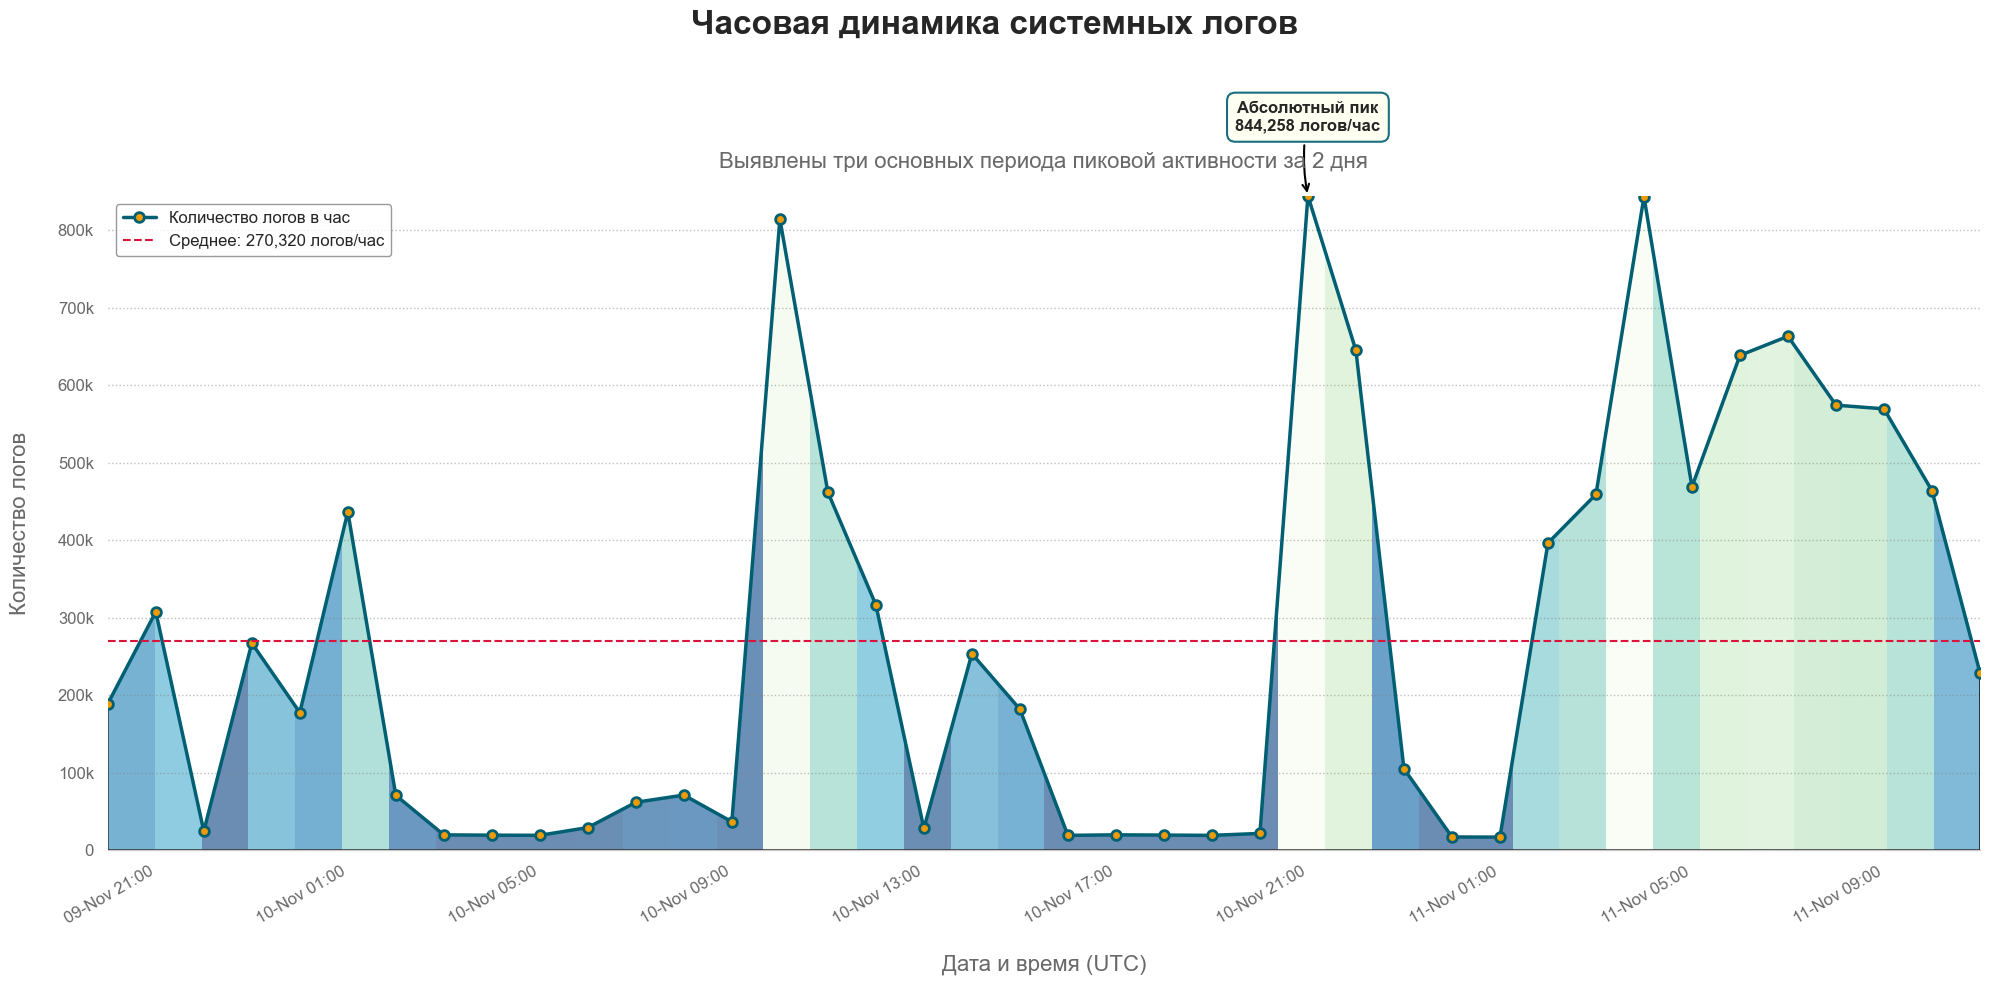

In [82]:
# Стиль и создание фигуры
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(20, 10))

# --- Данные для графика ---
x_data = hourly_counts_pd.index
y_data = hourly_counts_pd.values

# --- Основная линия графика ---
line_color = '#005f73' # Более темный, насыщенный циан
marker_color = '#ee9b00' # Теплый оранжевый для акцента
line, = ax.plot(
    x_data, y_data, color=line_color,
    linewidth=2.5, solid_capstyle='round', # Сглаженные концы линии
    marker='o', markersize=7, markerfacecolor=marker_color,
    markeredgecolor=line_color, markeredgewidth=2,
    label='Количество логов в час'
)

# Создаем невидимую заливку под кривой, чтобы использовать ее как маску
poly = ax.fill_between(x_data, y_data, facecolor='none')
# Создаем градиентное изображение
gradient_cmap = plt.cm.GnBu_r # Оттенки от зелено-голубого к светлому
img_extent = (mdates.date2num(x_data.min()), mdates.date2num(x_data.max()), 0, y_data.max())
im = ax.imshow(y_data.reshape(1, -1), cmap=gradient_cmap, aspect='auto', 
               extent=img_extent, origin='lower', alpha=0.6)
# Применяем маску к градиенту
im.set_clip_path(poly.get_paths()[0], transform=ax.transData)


# --- Акцент на максимальном и среднем значениях ---
# Максимум
peak_time = hourly_counts_pd.idxmax()
peak_value = hourly_counts_pd.max()
ax.annotate(
    f'Абсолютный пик\n{int(peak_value):,} логов/час',
    xy=(peak_time, peak_value),
    xytext=(0, 45), textcoords='offset points',
    ha='center', va='bottom',
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.1", color='black', lw=1.5),
    fontsize=12, fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.5", fc='ivory', ec=line_color, lw=1.5, alpha=0.9)
)

# Среднее
mean_value = hourly_counts_pd.mean()
ax.axhline(mean_value, color='crimson', linestyle='--', linewidth=1.5, label=f'Среднее: {int(mean_value):,} логов/час')

# --- Финальная настройка осей и заголовков ---
# Убираем лишние рамки
ax.spines[['top', 'right', 'left']].set_visible(False)

# Заголовок и подзаголовок
fig.suptitle('Часовая динамика системных логов', fontsize=24, fontweight='bold', y=0.98)
ax.set_title('Выявлены три основных периода пиковой активности за 2 дня', fontsize=16, pad=20, color='dimgray')

# Подписи осей
ax.set_xlabel('Дата и время (UTC)', fontsize=16, labelpad=20, color='dimgray')
ax.set_ylabel('Количество логов', fontsize=16, labelpad=20, color='dimgray')

# Форматирование оси Y (в тысячах "k")
ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{int(x/1000)}k' if x > 0 else '0'))
ax.get_yaxis().set_ticks_position('none') # Убираем тики на оси Y

# Форматирование оси X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
fig.autofmt_xdate(rotation=30, ha='right')

# Сетка
ax.grid(axis='y', linestyle=':', linewidth=1, color='gray', alpha=0.5)
ax.grid(axis='x', linestyle='none') # Убираем вертикальную сетку

# Настройка шрифтов для тиков
ax.tick_params(axis='both', which='major', labelsize=12, colors='dimgray', pad=10)
ax.tick_params(axis='x', bottom=False) # Убираем тики на оси X

# Легенда
ax.legend(loc='upper left', fontsize=12, frameon=True, facecolor='white', framealpha=0.8, edgecolor='gray')

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Оставляем место для suptitle
plt.show()